## Stimulus response habituation

The task and the simulated plot shown here is redrawn from the work of N. Timme and C. Lapish "A Tutorial for Information Theory in Neuroscience", 2018.

A sensory neuron $S$ responds to stimulation of the gill and siphon. This sensory neuron then makes a synapse on a motor neuron $M$ that controls the withdrawal muscle. It has been shown that the habituation process is due to changes in the synapse between the sensory neuron and the motor neuron. Excitatory connection from the stimulated neuron $S$ to the postsynaptic neuron $M$ decreased in strength with repeated stimulation via an exponential decay. Here is the simulation.

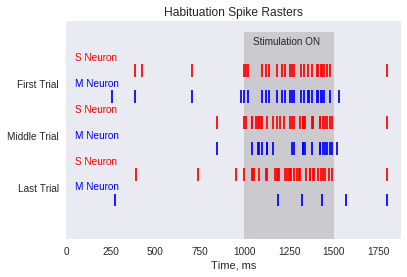

In [1]:
!pip install numpy==1.15.4 matplotlib==3.0.1
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

FIRING_RATE_NOISE = 0.005
FIRING_RATE_STIMULI = 0.1

STIMULI_START = 1000
STIMULI_DURATION = 500

SENSORY_MOTOR_STRENGTHS = (0.9, 0.5, 0.05)  # 3 trials; between 0 and 1

np.random.seed(26)


def generate_spikes(rate: float, duration: int):
    """
    :param rate: neuron's firing rate
    :param duration: experiment duration, ms
    :return: neuron spike raster with Gamma distributed inter-spike intervals
    """
    expected_size = int(rate * duration)
    t_spikes = []
    start = 0
    while True:
        intervals = np.random.gamma(shape=2, scale=1/rate, size=expected_size)
        t_spikes = np.r_[t_spikes, np.cumsum(intervals) + start]
        start = t_spikes[-1]
        if start >= duration:
            break
    t_spikes = t_spikes.astype(int).clip(max=duration-1)
    spikes = np.zeros(duration, dtype=int)
    spikes[t_spikes] = 1
    return spikes


def generate_sensory_spikes(rate: float, duration: int):
    noise = generate_spikes(rate=FIRING_RATE_NOISE, duration=duration)
    sensory_spikes = generate_spikes(rate=rate, duration=duration)
    sensory_spikes ^= noise
    return sensory_spikes


def generate_motor_spikes(sensory_spikes, connection_strength: float):
    assert 0 <= connection_strength <= 1
    p_spikes = np.random.uniform(low=0, high=1, size=len(sensory_spikes))
    noise = generate_spikes(rate=FIRING_RATE_NOISE, duration=len(sensory_spikes))
    motor_spikes = sensory_spikes * (p_spikes < connection_strength)
    motor_spikes ^= noise
    return motor_spikes


def generate_experiments():
    sensory_spikes_experiments = []
    motor_spikes_experiments = []
    for connection_strength in [0.9, 0.5, 0.05]:
        sensory_spikes = np.r_[generate_spikes(rate=FIRING_RATE_NOISE, duration=STIMULI_START),
                               generate_sensory_spikes(rate=FIRING_RATE_STIMULI, duration=STIMULI_DURATION),
                               generate_spikes(rate=FIRING_RATE_NOISE, duration=300)]
        sensory_spikes_experiments.append(sensory_spikes)
        motor_spikes = generate_motor_spikes(sensory_spikes=sensory_spikes, connection_strength=connection_strength)
        motor_spikes_experiments.append(motor_spikes)
    s = np.vstack(sensory_spikes_experiments)
    m = np.vstack(motor_spikes_experiments)
    return s, m


def visualize_spikes(sensory_spikes, motor_spikes):
    events = []
    colors = ['red', 'blue'] * 3
    for s, m in zip(sensory_spikes, motor_spikes):
        events.append(np.where(s)[0])
        events.append(np.where(m)[0])
    plt.bar(STIMULI_START, height=4, width=STIMULI_DURATION, align='edge', alpha=0.3, color='grey')
    lineoffsets = [3.25, 2.75, 2.25, 1.75, 1.25, 0.75]
    plt.eventplot(events, linelengths=0.25, lineoffsets=lineoffsets, colors=colors)
    plt.yticks(ticks=[3, 2, 1], labels=['First Trial', 'Middle Trial', 'Last Trial'])
    plt.xlim(left=0)
    plt.text(x=STIMULI_START + 50, y=3.75, s='Stimulation ON')
    for text, y, color in zip(['S Neuron', 'M Neuron'] * 3, lineoffsets, colors):
        plt.text(x=50, y=y + 0.2, s=text, color=color)
    plt.xlabel('Time, ms')
    plt.title('Habituation Spike Rasters')
    plt.grid(False)
    plt.show()


sensory_spikes, motor_spikes = generate_experiments()
visualize_spikes(sensory_spikes, motor_spikes)

How do you find at what trial (experiment) motor neuron M does not respond on the sensory neuron S? In other words, at what trial sensory and motor neurons spikes are independent?

In [2]:
# One way to answer this question is by analyzing what information the motor
# neuron M stores about the sensory neuron S. Low information indicates that
# their activations are nearly independent.

def discrete_entropy(digits) -> float:
    """
    :param digits: realizations of a discrete random variable X
    :return estimated entropy of X in bits
    """
    unique, counts = np.unique(digits, return_counts=True)
    proba = counts / len(digits)
    entropy = sum(proba * np.log2(1 / proba))
    return entropy


def discrete_mutual_information(x, y) -> float:
    """
    :param x: realizations of a discrete random variable X
    :param y: realizations of a discrete random variable Y
    :return: estimated mutual information between X and Y in bits
    """
    entropy_x = discrete_entropy(x)
    entropy_x_given_y = 0
    for y_unique in np.unique(y):
        mask = y == y_unique
        x_given_y = x[mask]
        entropy_x_given_y += discrete_entropy(x_given_y) * np.mean(mask)
    info = entropy_x - entropy_x_given_y
    return info


def describe(sensory_spikes, motor_spikes, mode=''):
    """
    Print entropy and mutual information between the sensory and motor neurons spikes.
    """
    print(f"\t{mode}: H(Sensor) = {discrete_entropy(sensory_spikes):.4f}, "
          f"H(Motor) = {discrete_entropy(motor_spikes):.4f}, "
          f"I(Sensor; Motor) = {discrete_mutual_information(sensory_spikes, motor_spikes):.4f}")


mask_stimulation = np.zeros(sensory_spikes.shape[1], dtype=bool)
mask_stimulation[STIMULI_START: STIMULI_START + STIMULI_DURATION] = True
for trial, (s, m) in enumerate(zip(sensory_spikes, motor_spikes)):
    print(f"Trial {trial}: connection_strength = {SENSORY_MOTOR_STRENGTHS[trial]}")
    describe(s[mask_stimulation], m[mask_stimulation], mode='stimulation')
    describe(s[~mask_stimulation], m[~mask_stimulation], mode='noise')

Trial 0: connection_strength = 0.9
	stimulation: H(Sensor) = 0.2603, H(Motor) = 0.2514, I(Sensor; Motor) = 0.2114
	noise: H(Sensor) = 0.0364, H(Motor) = 0.0425, I(Sensor; Motor) = 0.0152
Trial 1: connection_strength = 0.5
	stimulation: H(Sensor) = 0.3353, H(Motor) = 0.2423, I(Sensor; Motor) = 0.1620
	noise: H(Sensor) = 0.0235, H(Motor) = 0.0166, I(Sensor; Motor) = 0.0054
Trial 2: connection_strength = 0.05
	stimulation: H(Sensor) = 0.3274, H(Motor) = 0.0529, I(Sensor; Motor) = 0.0005
	noise: H(Sensor) = 0.0364, H(Motor) = 0.0235, I(Sensor; Motor) = 0.0042


At the first trial, when neurons S and M were strongly connected, neuron M preserved 0.2114 bits out of 0.2514 possible. On the last trial, however, when the connection strength decreased to 0.05, neuron M preserved only 0.0011 bits out of 0.0322 possible.

In this experiment we assumed that the neuron responses are completetly described by its firing rate and each trial is independent of the previous ones (has no memory). If it isn't the case, you should account inter-spikes intervals of the previous activations. Here are a few instruments:

* Transfer entropy measures the information about the future state of a variable ($Y_{future}$) provided by another variable in the past ($X_{past}$) given the information provided by the past state of the variable ($Y_{past}$). Once these temporal relationships are defined, transfer entropy can be interpreted as a better measure of causal influence from $X$ to $Y$ than merely the mutual information between $X_{past}$ and $Y_{future}$, because transfer entropy measures the changes caused in $Y$ from $X$ that are not accounted for by the history of $Y$ alone \[N. Timme, 2018]. Well suited for time-shifted responses.

$$TE(X \to Y) = I(Y_{future};X_{past}|Y_{past}) = H(Y_{future}|Y_{past}) - H(Y_{future}|X_{past},Y_{past})$$

* [Perform analysis in the frequency domain](https://www.researchgate.net/publication/12774896_Information_theory_and_neural_coding). This approach is especially useful since, firstly, in most cases, neuron's firing frequency does not depend on the other frequencies of the same neuron and, secondly, you don't need to discretize time. You can compute how many information is transmitted at each frequency and sum up the results.
* Binirize the rasters data in the smallest time resolution such that each bin has at most one spike count. Then count how many same subsequences of length $L$ are found in the full sequence of length $N > L$. You can compute entropy of the repeated _sequences_, not the firing rates. For example, in a sequence of 12 spikes $[[0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 1, 0]]$ the first two subsequences are repeated. This might be a pattern.